In [ ]:
# 任意位置横盘测试
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000001.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_high_low(df, filename, save_data=False, draw_n_days=400)
result = ha.find_horizontal_area(df, high_points, low_points, gamma=0.1, fft_percentile=100, min_len_of_window=3, ignore_hl=False)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=200, print_result=False, show_plot=True, save_plot=False)

In [ ]:
# MACD robust 任意位置横盘测试
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000001.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_hl_MACD_robust(df, filename, draw_n_days=400)
result = ha.find_horizontal_area(df, high_points, low_points, gamma=0.1, fft_percentile=100, min_len_of_window=3, ignore_hl=False)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=200, print_result=False, show_plot=True, save_plot=False)

In [ ]:
z,zz = hl.find_hl_MACD_robust(df, filename, fig_start_date='2000-1', fig_end_date='2001-12')

In [ ]:
from wave_price_change import *
waves = wave_idnetify(filename='000001.SZ.csv', alpha=0.05)
draw_waves(df, waves, '2020-12', '2021-10')

In [ ]:
# hl median测试
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000001.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_high_low(
    df, filename, save_data=False, draw=False)
result = ha.find_ha_near_hl_median(df, high_points, low_points, 0.03)
ha.draw_horizontal_area(df, result, high_points, low_points, filename,
                        n_days=270, print_result=False, show_plot=True, save_plot=False)


In [ ]:
# 对上方得到的data曲线进行DFT变换，得到频域上的信号
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
df = hl.df_init(filename)
data = df.tail(200)
data.plot(x='TRADE_DT', y='S_DQ_CLOSE', figsize=(20, 10))
# 对data进行DFT变换
data_fft = fft(data['S_DQ_CLOSE'].values)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(data_fft)
plt.show()
# 计算频谱中的总能量，并计算高频成分所占的比例。如果高频成分所占比例较小，那么曲线就比较平滑。
# 计算频谱中的总能量
energy = (data_fft * np.conj(data_fft)).real
# 计算高频成分所占的比例
high_freq_ratio = np.sum(energy[10:]) / np.sum(energy)
print(high_freq_ratio)
# 对高频成分进行滤波
data_fft_filtered = data_fft.copy()
data_fft_filtered[15:] = 0
# 对滤波后的数据进行逆变换
data_filtered = ifft(data_fft_filtered)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(data_filtered)
plt.show()

In [ ]:
# 对data曲线进行DFT变换，得到频域上的信号
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
df = hl.df_init(filename)
data = df.tail(200)
# 将data等分为20份，对每份按照上述方法求的高频成分所占比例
n = 20
data_list = np.array_split(data, n)
high_freq_ratio_list = []
for temp_data in data_list:
    data_fft = fft(temp_data['S_DQ_CLOSE'].values)
    energy = (data_fft * np.conj(data_fft)).real
    high_freq_ratio = np.sum(energy[3:]) / np.sum(energy)
    high_freq_ratio_list.append(high_freq_ratio)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(high_freq_ratio_list)
plt.show()
print(high_freq_ratio_list)
# 使用plt.axvspan将高频成分占比可视化到data曲线上，高频占比越高的区域颜色越深
plt.figure(figsize=(20, 10))
plt.plot(data['S_DQ_CLOSE'].values)
for i in range(len(high_freq_ratio_list)):
    plt.axvspan(i * 10, (i + 1) * 10, facecolor='r',
                alpha=high_freq_ratio_list[i] * 100)

In [ ]:
heal = 0
baoji = 0.51+0.32
baoshang = 0.61
loss = 0.9
a = round(567+0.8*(4655+2394*(1+heal))+(567+0.8*(4655+2394*(1+heal)))*baoji*(baoshang))
final = round(540+0.8*(4655+2394*(1+heal))+0.8*loss*(4655+2394*(1+heal))+(540+0.8*(4655+2394*(1+heal))+0.8*loss*(4655+2394*(1+heal)))*baoji*(baoshang))
print(a, final)

In [ ]:
heal = 0
baoji = 0.51
baoshang = 0.61+0.64
loss = 0.9
a = round(567+0.8*(4655+2394*(1+heal))+(567+0.8*(4655+2394*(1+heal)))*baoji*(baoshang))
final = round(540+0.8*(4655+2394*(1+heal))+0.8*loss*(4655+2394*(1+heal))+(540+0.8*(4655+2394*(1+heal))+0.8*loss*(4655+2394*(1+heal)))*baoji*(baoshang))
print(a, final)

In [ ]:
100*1.1

In [ ]:
import high_low_xuejie_zuhui as hl
df = hl.df_init('301335.SZ.csv')
z,zz = hl.find_high_low(df, '301335.SZ.csv')

In [4]:
import pandas as pd
import os
from tqdm import tqdm
import wave_price_change as wpc
from high_low_xuejie_zuhui import df_init

count = 0
all_waves = pd.DataFrame()
for filename in tqdm(os.listdir('/Users/kai/Desktop/qs/data_csv_distinct_0606'), leave=False):
    if filename.endswith('.csv'):
        # make sure filename is str
        waves = wpc.cal_price_change_rate(filename, alpha=0.05)
        all_waves = all_waves.append(waves)
        # count += 1
        # if count > 10:
        #     break

In [1]:
import pandas as pd
all_waves = pd.read_csv('/Users/kai/Desktop/qs/archive/all_waves.csv')

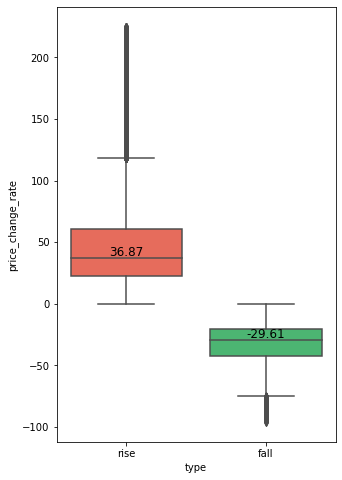

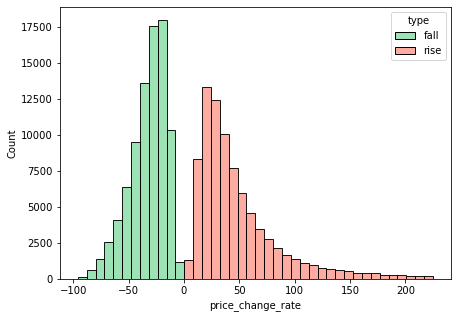

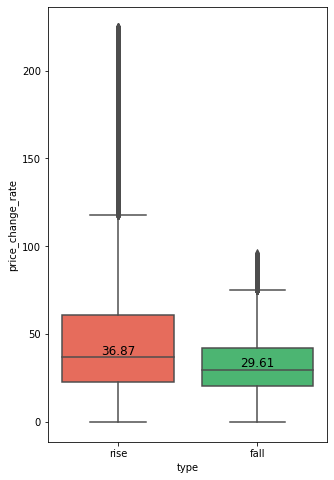

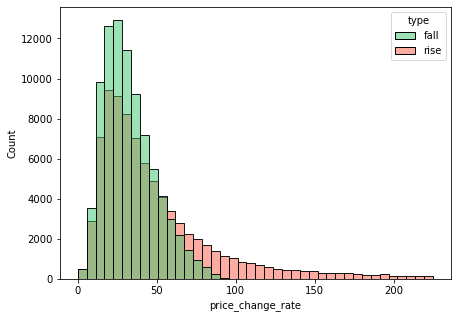

In [2]:
import wave_price_change as wpc
wpc.plot_pcg_rate(all_waves, 0.985)

In [10]:
# 计算all_waves的0,5,10,...,95,100分位数并保存csv
import pandas as pd
all_waves = pd.read_csv('/Users/kai/Desktop/qs/archive/all_waves.csv')
positive = all_waves[all_waves['price_change_rate']>=0]
negative = all_waves[all_waves['price_change_rate']<0]
positive['price_change_rate'].quantile([i/100 for i in range(0, 105, 5)]).to_csv('/Users/kai/Desktop/qs/archive/positive.csv')
negative['price_change_rate'].quantile([i/100 for i in range(0, 105, 5)]).to_csv('/Users/kai/Desktop/qs/archive/negative.csv')

In [ ]:
# 计算每只股票的买入卖出时间
from open_position import open_position
import pandas as pd
import high_low_xuejie_zuhui as hl
from close_position import close_position
import os
from tqdm import tqdm

for filename in tqdm(os.listdir('/Users/kai/Desktop/qs/data_csv_distinct_0606')):
    if filename.endswith('.csv'):
        df = hl.df_init(filename)
        buy_date = open_position(df)
        close_date = []
        if len(buy_date) == 0:
            continue
        for i in range(len(buy_date)):
            temp_close_date = close_position(df[df['TRADE_DT'] >= buy_date[i]])['date'].tolist()
            if len(temp_close_date) == 0:
                continue
            close_date.append(temp_close_date[0])
        # 为buy date和close date打上标签后合并，按照日期排序
        buy_date = pd.DataFrame(buy_date, columns=['date'])
        buy_date['type'] = 'buy'
        close_date = pd.DataFrame(close_date, columns=['date'])
        close_date['type'] = 'close'
        buy_close_date = pd.concat([buy_date, close_date], axis=0)
        buy_close_date.sort_values(by='date', inplace=True)
        buy_close_date.reset_index(drop=True, inplace=True)
        filename = filename[:-4]
        buy_close_date.to_csv('./buy_close_data/{}.csv'.format(filename), index=False)